# Introduction

In this exercise we are going to use an LHCb run-2 dataset to measure an angle of the CKM matrix. It is the real dataset, but in order for me not to get into trouble with the collaboration you do get a little less information than the LHCb analysts have. In particular, the answer will be less precise because you will only work with one finfal state and one 'flavour tagger'. Furthermore, you will miss essential input from a calibration channel that is needed to calibrate the observed asymmetry. But more about that later.

The learning goals of this exercise are:
* fitting with zfit, a python based modeling package based on Tensorflow. For more instructions, visit the zfit documentation.
* making s-plots and using s-weights for fitting
* extracting the CKM parameter `sin(2*beta)` from a time-dependent asymmetry.

The analysis will consist of two steps. In the first step you will learn about zfit and s-weights. In the second step you will measure sin(2*beta).

# The physics

We will discuss the physics in the lectures, but give a brief summary here. The 'golden channel' for measuring sin(2beta) is the decay $B^0 \to J/\psi K_s$, with $J/\psi\to \mu^+ \mu^-$ and $K_s \to \pi^+ \pi^-$. If you look at this final state, then you see that it is *CP symmetric*: replace every particle by anti-particle and vice versa, and you have the same final state. As a result the final state is equally accessible to a $B^0$ decay and an anti-$B^0$ decay.



# Exercise 1

Look up in the PDG (google `pdg live`) the quark content of these mesons: $B^0$, $J/\psi$, $K^0$. Draw the Feynman diagram for the decay $B^0 \to J/\psi \overline{K^0}$ (on a piece of paper, or on your tablet.)

Draw the mixing diagram for $B^0-\overline{B^0}$ and $K^0-\overline{K^0}$.

Show that the phase difference between the two amplitudes is ...

(It is long ago that I did this. Do this before finishing the exercise.)


# Prerequites

Install the `zfit` package.

In [50]:
# @ Prerequisites: install zfit. this will install uproot as well.
!pip install zfit
!pip install hepstats
!pip install mplhep


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 26.3 MB/s eta 0:00:00


# Exercise 2

Attached to this workbook you will find a 'ROOT' file. The file contains a TTree (named `tree`) with a number of fields (called `branches` in ROOT language). For the rest of the exercise, the relevant fields are:
* `mass`: the B candidate invariant mass in MeV
* `decaytime`: the B candidate decaytime in ns
* `q`: the charge of the B candidate reconstructed by the flavour tagging algorithm
* `eta`: the mistagrate assigned by the flavour tagging algorithm

Load the dataset with your favourite tool and draw the reconstructed invariant mass. If you plot it on a log scale, you will find three peaks on a falling exponential background. Knowing that this is a decay to $J/\psi K_s$ and using rhe PDG, identify the two peaks on the right. What is the left-most peak?

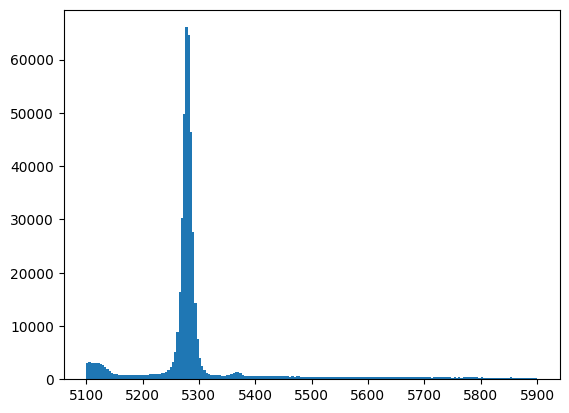

In [3]:
#@title Example solution
# This is a partial solution to the exercise using uproot. You can also use pyroot if you prefer.
# url ='https://github.com/wouterhuls/sin2beta/raw/main/ntuple_for_BND.root'
url = 'http://www.nikhef.nl/~wouterh/tmp/ntuple_for_BND.root'

import uproot
events = uproot.open(url + ":tree")
mass = events["mass"].array()

import matplotlib.pyplot as plt
plt.hist(mass, bins=200)
plt.show()

# Hint: you will see a lot more if you plot on a log scale and with more bins!

# Exercise 3

Draw also the B candidate 'decaytime'. The units are in nanoseconds. Compute the average decaytime and its statistical error. How does the answer compare to the average $B^0$ lifetime in the PDG? Give two reasons why the two are different.

Make a profile plot with the average decay time versus the mass.


# Exercise 4

We will now perform a fit to the invariant mass distribution to extract the number of $B^0$ events. Because it may take you too much time to figure this out yourself, we have written most of the code for you.

If you look at the final fit result superimposed on the data set, it looks pretty bad. One reason is the 'signal mass model': it is not very well described by a Gaussian. The other reason is that the $B_s$ peak is not modeled. **Your exercise: add a third component to the mass pdf to model the $B_s$ decay.**

*Hint: The shape of the $B_s$ mass peak is essentially identical to that of the $B_0$. The fit is more stable if the only 'free' parameter of the $B_s$ model is the yield. You can reuse the 'sigma' parameter of the $B_0$ pdf, but the mean is shifted. To get the shifted 'mu' for the $B_s$, use

Bonus exercise:

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_65, Composed_autoparam_66, Composed_autoparam_67]] data=[<zfit.core.data.Data object at 0x7fc417069330>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.3e-05 │ -35303.5    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)        hesse    at limit
---------  ------------------  -----------  ----------
yield_B0               334056  +/- 5.9e+02       False
yield_bkg              105586  +/- 3.7e+02       False
yield_Bs              2896.85  +/-      96       False
mu_B0                 5279.58  +/-   0.016       False
sigma_B0               8.7388  +/-   0.014     

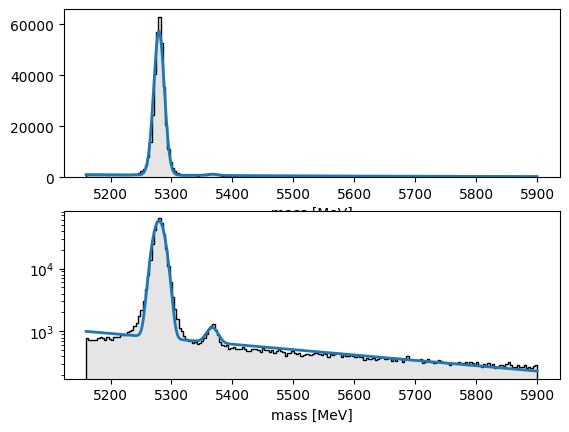

In [29]:
import zfit
import numpy as np

# Specify the mass range. To simplify the fit, we first limit the mass range to the region just around the B0 mass peak.
massmin = 5160
massmax = 5900

#massmax = 5330

# temporary hack, to make sure we can rerun this cell as often as we like.
from collections import OrderedDict
zfit.core.parameter.ZfitParameterMixin._existing_params = OrderedDict()

# use uproot to get the subset of events in this mass range in numpy format
npevents = events.arrays( library='np',expressions=['mass','decaytime','masserr'] )
mass = npevents[ 'mass' ]
masserr = npevents[ 'masserr' ]
decaytime = npevents['decaytime']

# use a little bit complicated logic to get access to the events in the narrow
# mass range in such a way that we can still identify the events in the
# original list. (we need that later)
mask = np.logical_and(mass>massmin,mass<massmax,masserr<10)
indices = np.where(mask)

# create a zfit data set from the numpy array. when constructing a zfit dataset
# from a numpy array we need to tell how we 'name' the columns
massobs = zfit.Space("mass",(massmin,massmax))
zdata = zfit.Data.from_numpy( array = mass[indices], obs = massobs )

# create a zfit pdf for the B0 signal
mu_B0 = zfit.Parameter("mu_B0", 5279, 5250, 5300)
sigma_B0 = zfit.Parameter("sigma_B0", 10, 0, 30)
masspdf_B0 = zfit.pdf.Gauss(mu=mu_B0, sigma=sigma_B0, obs=massobs)

# create a zfit pdf for the exponential background
lambd = zfit.Parameter("lambda", -0.001, -1,+1)
masspdf_bkg = zfit.pdf.Exponential(lambd, obs=massobs)

# create a zfit pdf for the Bs signal. here is a trick that you need:
sigma_Bs = sigma_B0
#def mu_Bs_func(params): return params + 87.45 # mass shift
#mu_Bs = zfit.ComposedParameter("mu_Bs",mu_Bs_func, params=[mu_B0])
mu_Bs = zfit.Parameter("mu_Bs", 5366., 5350., 5380.)
masspdf_Bs = zfit.pdf.Gauss(mu=mu_Bs, sigma=sigma_Bs, obs=massobs)

# create an extended PDF from the sum of these
nev = len( mass )
yield_B0  = zfit.Parameter("yield_B0", 0.9*nev, -0.1*nev, 1.1*nev)
yield_Bs  = zfit.Parameter("yield_Bs", 0.05*nev, -0.1*nev, 1.1*nev)
yield_bkg = zfit.Parameter("yield_bkg", 0.1*nev, -0.1*nev, 1.1*nev)
extmasspdf_B0  = masspdf_B0.create_extended(yield_ = yield_B0)
extmasspdf_Bs  = masspdf_Bs.create_extended(yield_ = yield_Bs)
extmasspdf_bkg = masspdf_bkg.create_extended(yield_ = yield_bkg)
pdf_total  = zfit.pdf.SumPDF([extmasspdf_B0, extmasspdf_bkg, extmasspdf_Bs], name="totPDF")

# create a loss function. this is what we will 'minimize'
nll_data = zfit.loss.ExtendedUnbinnedNLL(model=pdf_total, data=zdata)
# create the minimizer. This one uses minuit, but there are various alternatives.
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_data)
result.hesse()
print(result)

# draw the result
n_bins = 200
npdata = zdata['mass'].numpy()
plot_scaling = len(npdata) / n_bins * massobs.area()
x = np.linspace(massmin,massmax, 1000)
y = pdf_total.pdf(x).numpy()
fig, axes = plt.subplots(2)
axes[1].set_yscale("log")
for i in range(2):
  axis = axes[i]
  color = 'black'
  axis.hist(npdata, color=color, bins=n_bins, histtype="stepfilled", alpha=0.1)
  axis.hist(npdata, color=color, bins=n_bins, histtype="step")
  axis.plot(x, y * plot_scaling, label="Sum - Model", linewidth=2)
  axis.set_xlabel("mass [MeV]")
plt.show()


FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_77, Composed_autoparam_78, Composed_autoparam_79]] data=[<zfit.core.data.Data object at 0x7fc417069330>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00021 │ -1099.144   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)        hesse    at limit
---------  ------------------  -----------  ----------
yield_B0               344112  +/- 6.3e+02       False
yield_bkg             94662.2  +/-   4e+02       False
yield_Bs              3763.88  +/-   1e+02       False
mu_B0                 5279.68  +/-   0.016       False
sigma_B0               7.5374  +/-   0.028     

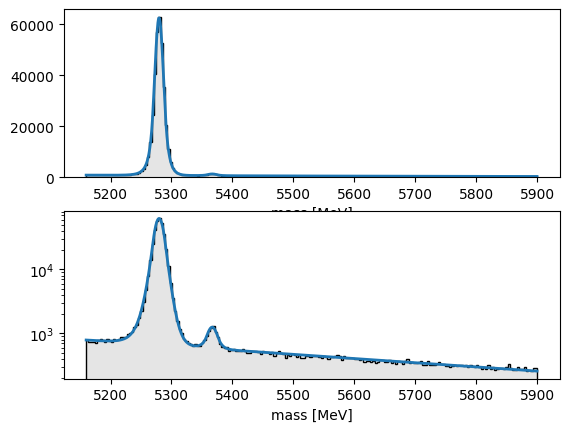

In [33]:
# repeat the fit but with a better mass model
zfit.core.parameter.ZfitParameterMixin._existing_params = OrderedDict()

aL = zfit.Parameter("aL_B0",  1.4, 0.1, 5,floating=True)
aR = zfit.Parameter("aR_B0",  1.4, 0.1, 5,floating=True)
aR = aL
nL = zfit.Parameter("nL_B0", 6, 1., 10, floating=True)
nR = zfit.Parameter("nR_B0", 10, 1., 20,floating=True)

masspdf_B0 = zfit.pdf.DoubleCB(obs=massobs, mu=mu_B0, sigma=sigma_B0, alphal=aL, nl=nL, alphar=aR, nr=nR)
masspdf_Bs = zfit.pdf.DoubleCB(obs=massobs, mu=mu_Bs, sigma=sigma_B0, alphal=aL, nl=nL, alphar=aR, nr=nR)

#masspdf_B0 = zfit.pdf.CrystalBall(obs=massobs, mu=mu_B0, sigma=sigma_B0, alpha=aL, n=nL)
#masspdf_Bs = zfit.pdf.CrystalBall(obs=massobs, mu=mu_Bs, sigma=sigma_B0, alpha=aL, n=nL)


extmasspdf_B0  = masspdf_B0.create_extended(yield_ = yield_B0)
extmasspdf_Bs  = masspdf_Bs.create_extended(yield_ = yield_Bs)
extmasspdf_bkg = masspdf_bkg.create_extended(yield_ = yield_bkg)
pdf_total  = zfit.pdf.SumPDF([extmasspdf_B0, extmasspdf_bkg, extmasspdf_Bs], name="totPDF")

nll_data = zfit.loss.ExtendedUnbinnedNLL(model=pdf_total, data=zdata)
# create the minimizer. This one uses minuit, but there are various alternatives.
result = minimizer.minimize(nll_data)
result.hesse()
print(result)

# draw the result
n_bins = 200
npdata = zdata['mass'].numpy()
plot_scaling = len(npdata) / n_bins * massobs.area()
x = np.linspace(massmin,massmax, 1000)
y = pdf_total.pdf(x).numpy()
fig, axes = plt.subplots(2)
axes[1].set_yscale("log")
for i in range(2):
  axis = axes[i]
  color = 'black'
  axis.hist(npdata, color=color, bins=n_bins, histtype="stepfilled", alpha=0.1)
  axis.hist(npdata, color=color, bins=n_bins, histtype="step")
  axis.plot(x, y * plot_scaling, label="Sum - Model", linewidth=2)
  axis.set_xlabel("mass [MeV]")
plt.show()


In [35]:
# @ compute s-weights and make a decaytime plot

# we can get rid of the masks if we only work with the selected events. that actually makes a bit more sense.
from hepstats.splot import compute_sweights
sweights_all = compute_sweights(pdf_total, npdata)
sweights_B0 = np.zeros_like( mass, dtype=np.float64 )
sweights_Bs = np.zeros_like( mass, dtype=np.float64 )
np.place(sweights_B0, mask, sweights_all[yield_B0] )
np.place(sweights_Bs, mask, sweights_all[yield_Bs] )


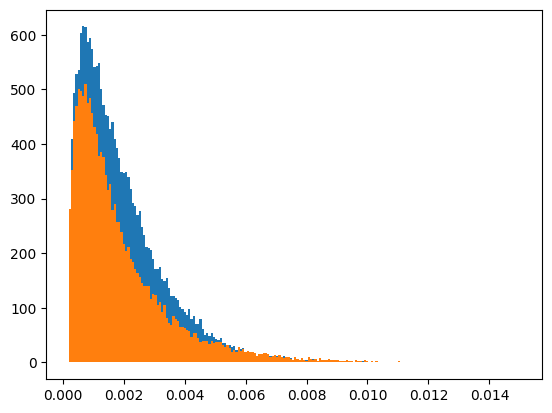

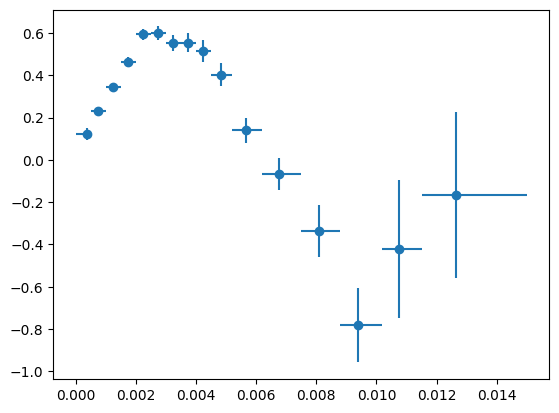

In [72]:
# plot the s-weighted decay time distribution
import matplotlib.pyplot as plt
decaytime = npevents['decaytime']
q = events["q"].array()
eta = events["eta"].array()
plt.hist(decaytime, bins=200, weights = sweights_B0 * (q<0)* (1-2*eta))
plt.hist(decaytime, bins=200, weights = sweights_B0 * (q>0)* (1-2*eta))
plt.show()

# suggested binning for asymmetry plot
#tbins = np.concatenate((np.arange(0.0000,5.0,step=0.5),[5.6,6.2,7.0,7.8,8.7,9.7,10.8,12.0,13.4,15.]))
tbins = np.array([0.002,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.2,6.2,7.5,8.8,10.2,11.5,15.])
tbins = tbins/1000.

# choose 20 bins with equal number of events
#tbins = np.quantile(decaytime, np.linspace(start=0.0,stop=1.0,num=21)[1:])
#tbins[-1] = 0.015
#tbins[0]  = 0.0002

# I'm not sure how to do this properly
qD = q*(1-2*eta)*-1
wqDsum, bin_edges  = np.histogram(decaytime,bins=tbins,weights=sweights_B0*qD)
wqD2sum, bin_edges = np.histogram(decaytime,bins=tbins,weights=sweights_B0*qD*qD)
w2qD2sum, bin_edges = np.histogram(decaytime,bins=tbins,weights=sweights_B0*sweights_B0*qD*qD)
asymmetry    = wqDsum / wqD2sum
asymmetryerr = np.sqrt(w2qD2sum) / wqD2sum

# compute in every bin the average decay time
wtsum, bin_edges = np.histogram(decaytime,bins=tbins,weights=sweights_B0*decaytime)
wsum,  bin_edges = np.histogram(decaytime,bins=tbins,weights=sweights_B0)
avtime = wtsum / wsum

# now draw points with both vertical and horizontal errors
xerrors = [avtime-bin_edges[:-1],bin_edges[1:]-avtime]
plt.errorbar(x=avtime, y=asymmetry, xerr=xerrors, yerr=asymmetryerr,fmt='o')
plt.show()



# compute s-weights corresponding to each of the yields

S = 0.606 +/- 0.013
[0.75169212 0.00540457]
S = 0.604 +/- 0.015
C = 0.004 +/- 0.014


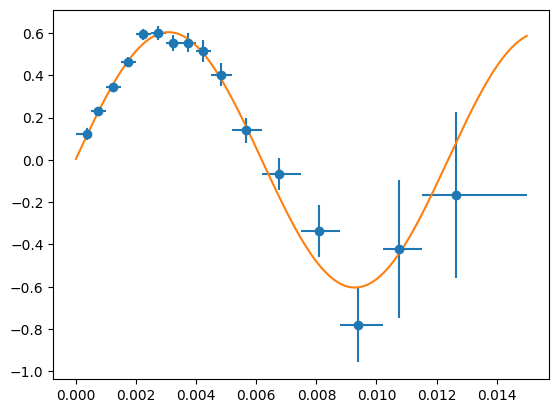

In [88]:
# define a model and fit to s-weighted data

# for now, just measure the amplitude of the sin-wave
# this only works because C=0
deltaM = 507. # mixing frequency in [2pi/ns]
qDsin = qD * np.sin(decaytime*deltaM)
wqDsinsum = np.sum( sweights_B0*qDsin )
wqDsin2sum = np.sum( sweights_B0*np.square(qDsin) )
w2qDsin2sum = np.sum( np.square(sweights_B0*qDsin) )

Sasymmetry    = wqDsinsum / wqDsin2sum
Sasymmetryerr = np.sqrt(w2qDsin2sum) / wqDsin2sum
print("S = %5.3f +/- %5.3f" %(Sasymmetry,Sasymmetryerr))

# the following code extracts S and C simultanously
qDcos = qD * np.cos(decaytime*deltaM)
wqDcossum = np.sum( sweights_B0*qDcos )
wqDcos2sum = np.sum( sweights_B0*np.square(qDcos) )
w2qDcos2sum = np.sum( np.square(sweights_B0*qDcos) )
wqD2cossinsum = np.sum( sweights_B0*qDcos*qDsin )
w2qD2cossinsum = np.sum( np.square(sweights_B0)*qDcos*qDsin )

b = np.array( [ wqDsinsum,wqDcossum] )

A = np.array( [[wqDsin2sum,wqD2cossinsum],[wqD2cossinsum,wqDcos2sum]] )
x = np.linalg.solve(A,b)
print(x/0.803)
S = x[0]
C = x[1]

# the only thing to do is to get the weights squared correction
wqD2cossinsum = np.sum( sweights_B0*qDcos*qDsin )
B = np.array( [[w2qDsin2sum,w2qD2cossinsum],[w2qD2cossinsum,w2qDcos2sum]] )
Ainv = np.linalg.inv(A)
cov = Ainv @ B @ Ainv

print("S = %5.3f +/- %5.3f" %(S,np.sqrt(cov[0,0])))
print("C = %5.3f +/- %5.3f" %(C,np.sqrt(cov[1,1])))


# create a function to superimpose on the asymmetry
x = np.linspace(0,0.015, 1000)
y = S*np.sin(x*deltaM) + C*np.cos(x*deltaM)
plt.errorbar(x=avtime, y=asymmetry, xerr=xerrors, yerr=asymmetryerr,fmt='o')
plt.plot(x,y)
plt.show()


